In [42]:
import numpy as np
import keras_tuner as kt
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math


## Load the dataset

(1, 4000, 1)
(1, 4000, 1)
(1, 1000, 1)
(1, 1000, 1)
(1, 5000, 1)
(1, 5000, 1)


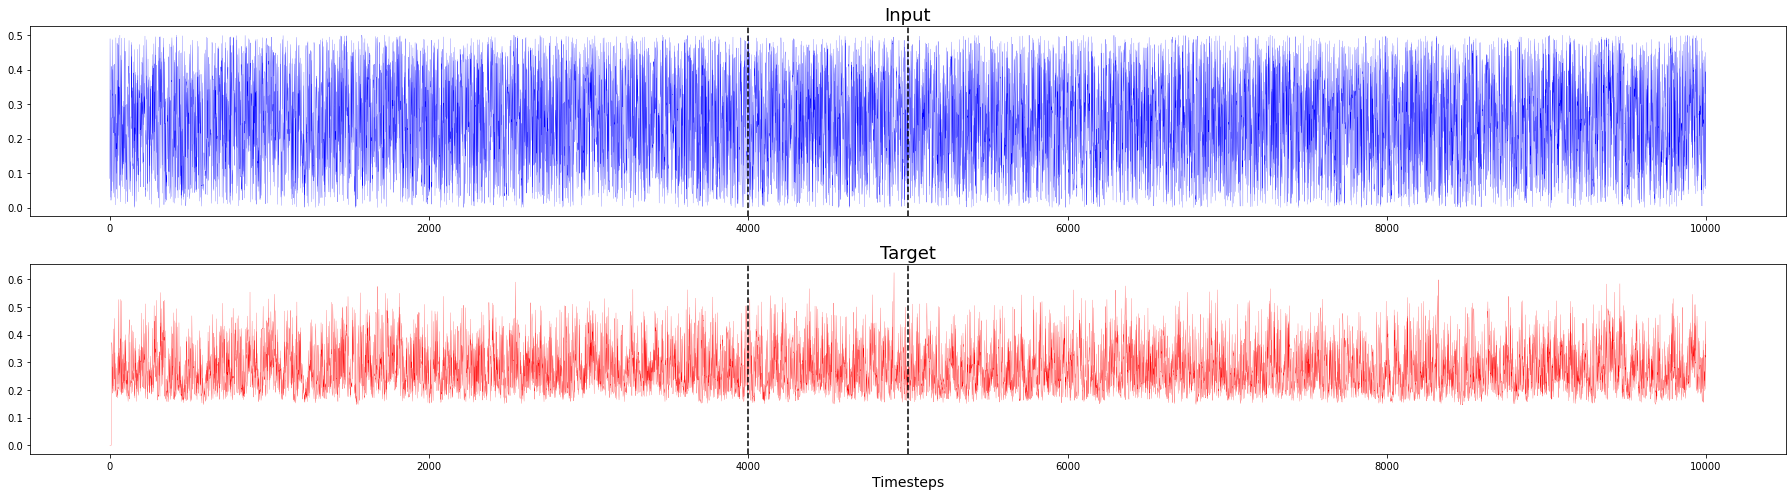

In [43]:
#load the data
x, y = np.loadtxt("NARMA10.csv", delimiter=",")


#split the dataset into training, validation and test
x_train = x[:4000]
x_valid = x[4000:5000] #validation
x_test = x[5000:]

y_train = y[:4000]
y_valid = y[4000:5000]
y_test = y[5000:]

#plot the data
t=np.arange(start=0,stop=len(x), step=1)
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(t,x, color = 'b', linewidth= 0.2)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')

ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(t,y, color = 'r', linewidth = 0.2)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()


X_train = np.reshape(x_train, (1,len(x_train),1))
Y_train = np.reshape(y_train, (1,len(y_train),1))

X_valid = np.reshape(x_valid, (1,len(x_valid),1))
Y_valid = np.reshape(y_valid, (1,len(y_valid),1))

X_test = np.reshape(x_test, (1,len(x_test),1))
Y_test = np.reshape(y_test, (1,len(y_test),1))

print(X_train.shape)
print(Y_train.shape)

print(X_valid.shape)
print(Y_valid.shape)

print(X_test.shape)
print(Y_test.shape)


## RNN
### Create the model
Actually we create the "hypermodel", defining the hyperparameter search space as well as the architecture of the model.

In [44]:
def model_architecture(lr, hidden_units, activation_h, activation_d):
    model = Sequential()
    model.add(SimpleRNN(hidden_units,
                        activation=activation_h, return_sequences=True, stateful = True, batch_input_shape=(1,None,1))) #stateful = True
    model.add(Dense(units=1, activation=activation_d))
    
    # Tune the learning rate for the optimizer
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr),metrics=['mean_squared_error'])
    return model


def create_model(hp):

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 10-100
    hidden_units = hp.Int('units',  min_value=10, max_value=300, step=10)

    #Tune the activation function of the hidden layer
    activation_h = hp.Choice("activation_h", ["linear","relu"])

    #Tune the activation function of the dense layer
    activation_d = hp.Choice("activation_d", ["linear","relu", "tanh"])

    # Tune the learning rate for the optimizer
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


    # call model-building code with the hyperparameter values.
    model = model_architecture( hidden_units = hidden_units, activation_h = activation_h, activation_d = activation_d,
        lr=lr
    )
    return model

In [45]:
#Instantiate hyperparameter tuner
tuner = kt.RandomSearch(
                     hypermodel =create_model,
                     objective='val_mean_squared_error',
                     max_trials=25,
                     overwrite=True,
                     directory='tuner',
                     project_name='tuner_rnn'
                     )

In [46]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 300, 'step': 10, 'sampling': 'linear'}
activation_h (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu'], 'ordered': False}
activation_d (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [47]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [48]:
tuner.search(X_train, Y_train, epochs=100, validation_data = (X_valid, Y_valid))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"""
Completed hyperparameters search.\n
Otimal number of units of hidden layer = {best_hps.get('units')} \n
Optimal learning rate for the optimizer = {best_hps.get('learning_rate')} \n
Optimal activation function for the hidden layer = {best_hps.get('activation_h')} \n
Optimal activation function for the dense layer = {best_hps.get('activation_d')}
""")


Trial 25 Complete [00h 01m 02s]
val_mean_squared_error: nan

Best val_mean_squared_error So Far: 0.0012309810845181346
Total elapsed time: 00h 24m 12s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



Completed hyperparameters search.

Otimal number of units of hidden layer = 180 

Optimal learning rate for the optimizer = 0.001 

Optimal activation function for the hidden layer = relu 

Optimal activation function for the dense layer = tanh



Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [49]:
# Build the model with the optimal hyperparameters and train it on the data for 300 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=500, verbose=2, validation_data = (X_valid, Y_valid))

Epoch 1/500
1/1 - 2s - loss: 0.0926 - mean_squared_error: 0.0926 - val_loss: 0.0669 - val_mean_squared_error: 0.0669 - 2s/epoch - 2s/step
Epoch 2/500
1/1 - 1s - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - 587ms/epoch - 587ms/step
Epoch 3/500
1/1 - 1s - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - 560ms/epoch - 560ms/step
Epoch 4/500
1/1 - 1s - loss: 0.0271 - mean_squared_error: 0.0271 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - 589ms/epoch - 589ms/step
Epoch 5/500
1/1 - 1s - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - 551ms/epoch - 551ms/step
Epoch 6/500
1/1 - 1s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - 660ms/epoch - 660ms/step
Epoch 7/500
1/1 - 1s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - 580ms/epoch - 580ms/ste

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (1, None, 180)            32760     
                                                                 
 dense_1 (Dense)             (1, None, 1)              181       
                                                                 
Total params: 32,941
Trainable params: 32,941
Non-trainable params: 0
_________________________________________________________________


In [51]:
val_mse_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 474


Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [52]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(X_train, Y_train, epochs=best_epoch, verbose=2, validation_data = (X_valid, Y_valid)).history

Epoch 1/474
1/1 - 1s - loss: 0.0807 - mean_squared_error: 0.0807 - val_loss: 0.0560 - val_mean_squared_error: 0.0560 - 1s/epoch - 1s/step
Epoch 2/474
1/1 - 1s - loss: 0.0566 - mean_squared_error: 0.0566 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - 509ms/epoch - 509ms/step
Epoch 3/474
1/1 - 1s - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - 521ms/epoch - 521ms/step
Epoch 4/474
1/1 - 0s - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - 474ms/epoch - 474ms/step
Epoch 5/474
1/1 - 0s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - 479ms/epoch - 479ms/step
Epoch 6/474
1/1 - 0s - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - 453ms/epoch - 453ms/step
Epoch 7/474
1/1 - 1s - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - 520ms/epoch - 520ms/ste

### Make plots of the loss and validation loss

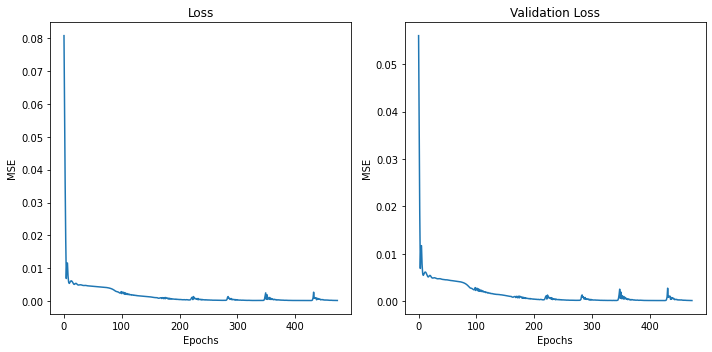

In [53]:
plt.figure(figsize = (10,5))

plt.subplot(121)
plt.plot(history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.subplot(122)
plt.plot(history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.tight_layout()
plt.show()

In [54]:
hypermodel.save('keras_model_rnn')

2023-05-04 18:41:48.113639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [1,?,180]
	 [[{{node inputs}}]]
2023-05-04 18:41:48.446273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [1,?,180]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: keras_model_rnn/assets


INFO:tensorflow:Assets written to: keras_model_rnn/assets


In [55]:
#hypermodel = keras.models.load_model('keras_model_rnn')

### Plots of target and output signals over time

1/1 [==============================] - 0s 241ms/step - loss: 2.5702e-04 - mean_squared_error: 2.5702e-04


1/1 [==============================] - 0s 163ms/step - loss: 1.3729e-04 - mean_squared_error: 1.3729e-04


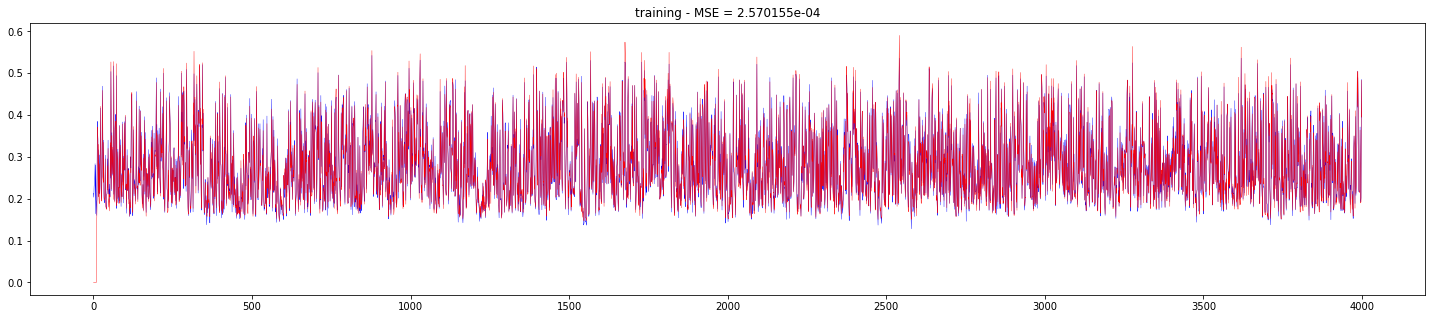

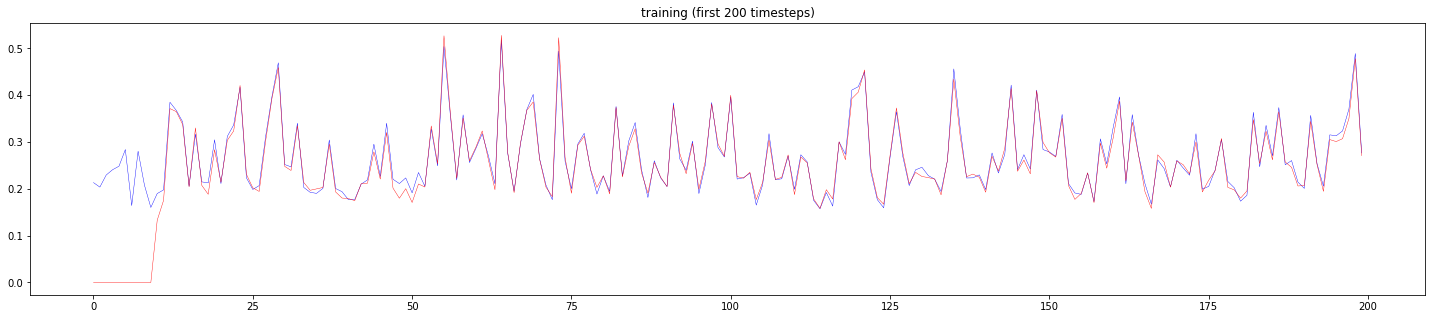

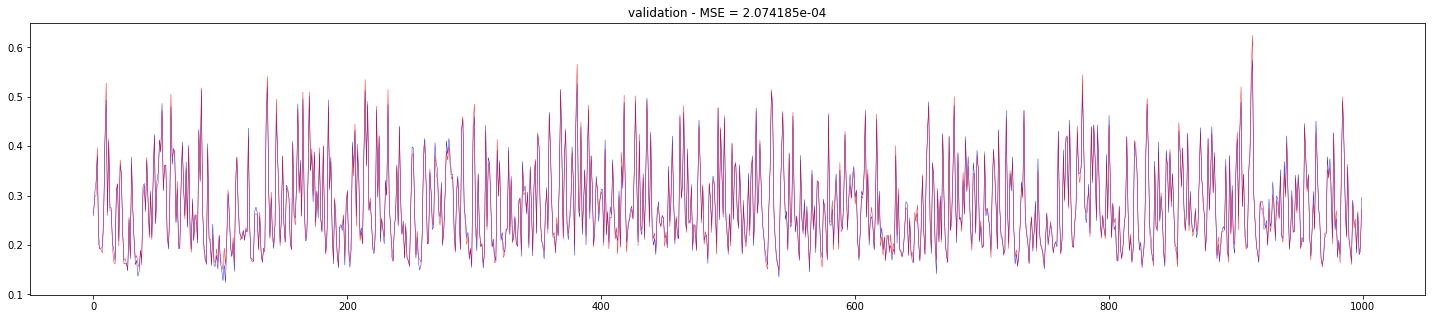

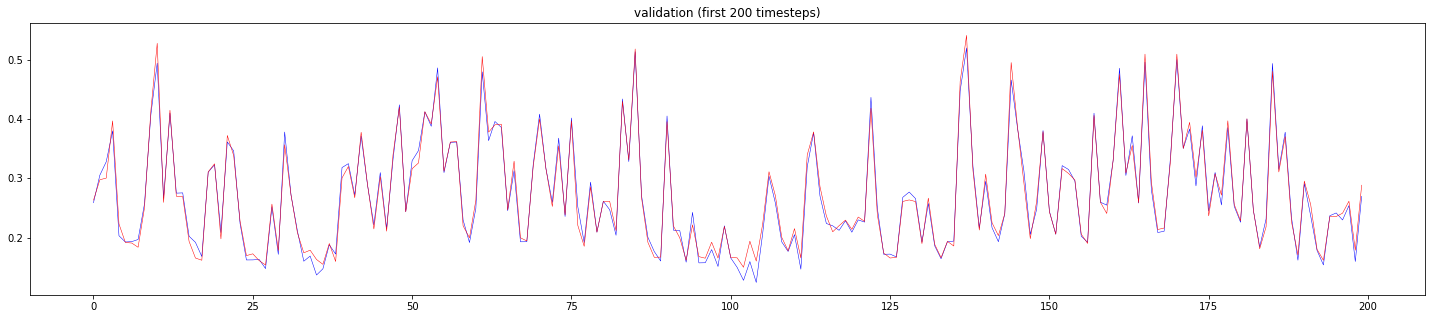

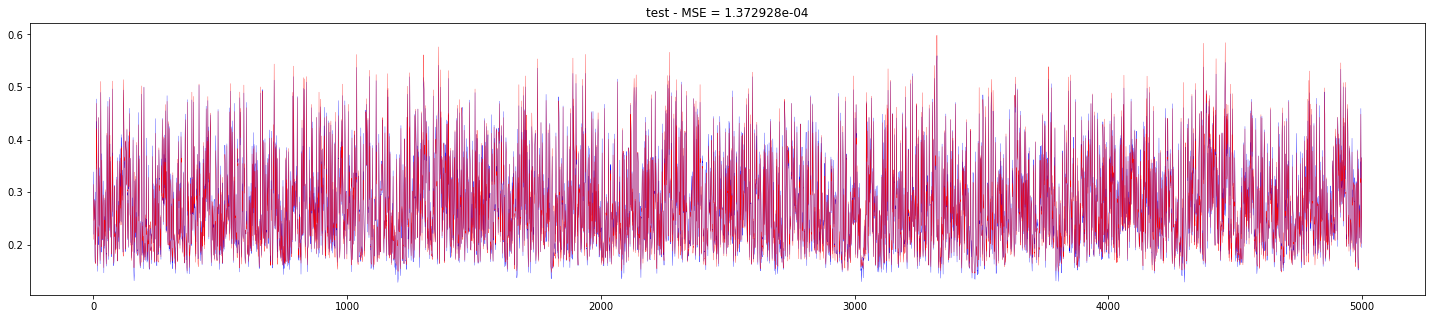

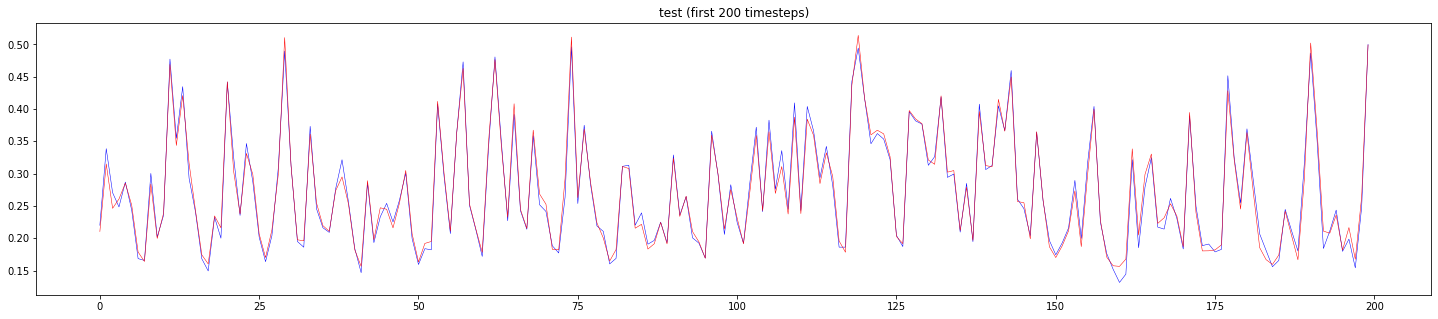

In [56]:
#training

y = hypermodel.predict(X_train)
mse = hypermodel.evaluate(X_train, Y_train)[0]
t=np.arange(start=0,stop=len(X_train[0]), step=1)
plt.figure(figsize = (25,5))
plt.title(f'training - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4)
plt.plot(t,Y_train.ravel(), color = 'r', linewidth= 0.4)

plt.figure(figsize = (25,5))
plt.title('training (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4)
plt.plot(t[:200],Y_train.ravel()[:200], color = 'r', linewidth= 0.4)

#validation

y = hypermodel.predict(X_valid)
mse = hypermodel.evaluate(X_valid, Y_valid)[0]
t=np.arange(start=0,stop=len(X_valid[0]), step=1)
plt.figure(figsize = (25,5))
plt.title(f'validation - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4)
plt.plot(t,Y_valid.ravel(), color = 'r', linewidth= 0.4)

plt.figure(figsize = (25,5))
plt.title('validation (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.5)
plt.plot(t[:200],Y_valid.ravel()[:200], color = 'r', linewidth= 0.5)

#test

y = hypermodel.predict(X_test)
mse = hypermodel.evaluate(X_test, Y_test)[0]
t=np.arange(start=0,stop=len(Y_test[0]), step=1)
plt.figure(figsize = (25,5))
plt.title(f'test - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.3)
plt.plot(t,Y_test.ravel(), color = 'r', linewidth= 0.3)

plt.figure(figsize = (25,5))
plt.title('test (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.5)
plt.plot(t[:200],Y_test.ravel()[:200], color = 'r', linewidth= 0.5)

